# Breast Cancer Wisconsin

### Step 1: Import Libraries

In [ ]:
import pandas as pd
import zipfile
import os
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE  # For handling class imbalance
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

### Step 2: Load Data

In [ ]:
# Unzipping the file
with zipfile.ZipFile('Breast Cancer Wisconsin.zip', 'r') as zip_ref:
    zip_ref.extractall('Breast_Cancer_Wisconsin')

# Get list of all files in the extracted folder
file_list = os.listdir('Breast_Cancer_Wisconsin')

# Load the CSV file into a DataFrame
csv_file = [file for file in file_list if file.endswith('.csv')][0]
df = pd.read_csv(f'Breast_Cancer_Wisconsin/{csv_file}')

### Step 3: Data Preprocessing

In [ ]:
df.drop(['id', 'Unnamed: 32'], axis=1, errors='ignore', inplace=True)  # Drop unnecessary columns
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})  # Convert diagnosis to binary
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

### Step 4: Train and Evaluate Models

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)

# Logistic Regression Model
lr_model = LogisticRegression(max_iter=10000, random_state=42)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr)}")
print(classification_report(y_test, y_pred_lr))

# Support Vector Machine (SVM)
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print("\nSVM Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm)}")
print(classification_report(y_test, y_pred_svm))

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("\nRandom Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(classification_report(y_test, y_pred_rf))

### Step 5: Confusion Matrix

In [ ]:
# Confusion Matrix for Random Forest
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.title('Random Forest Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Cross-validation for Random Forest
cv_scores_rf = cross_val_score(rf_model, X_scaled, y_resampled, cv=5)
print(f"\nCross-validation scores for Random Forest: {cv_scores_rf}")
print(f"Mean CV score: {cv_scores_rf.mean()}")

### Step 6: Hypterparameter and Evluate Best Model

In [ ]:
# Hyperparameter Tuning with GridSearchCV (for Random Forest)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy')
rf_grid_search.fit(X_train, y_train)
print(f"\nBest Parameters from GridSearchCV: {rf_grid_search.best_params_}")

best_rf_model = rf_grid_search.best_estimator_

# Predictions and evaluation for the best model
y_pred_best_rf = best_rf_model.predict(X_test)
print("\nBest Random Forest Performance after Hyperparameter Tuning:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best_rf)}")
print(classification_report(y_test, y_pred_best_rf))

### Step 7: Save

In [ ]:
# Model Saving
joblib.dump(best_rf_model, 'breast_cancer_rf_model.pkl')
print("\nBest Random Forest Model saved successfully!")

In [1]:
import pandas as pd
import zipfile
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
import seaborn as sns
import joblib
import shap  # For model interpretability

In [2]:
# Unzipping the file
with zipfile.ZipFile('Breast Cancer Wisconsin.zip', 'r') as zip_ref:
    zip_ref.extractall('Breast_Cancer_Wisconsin')

# Get list of all files in the extracted folder
file_list = os.listdir('Breast_Cancer_Wisconsin')

# Load the CSV file into a DataFrame
csv_file = [file for file in file_list if file.endswith('.csv')][0]
df = pd.read_csv(f'Breast_Cancer_Wisconsin/{csv_file}')

print(df.info())
print(df.describe())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

C:\Users\milto\AppData\Local\Temp\ipykernel_1568\2354905939.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['diagnosis'], palette=['blue', 'red'])


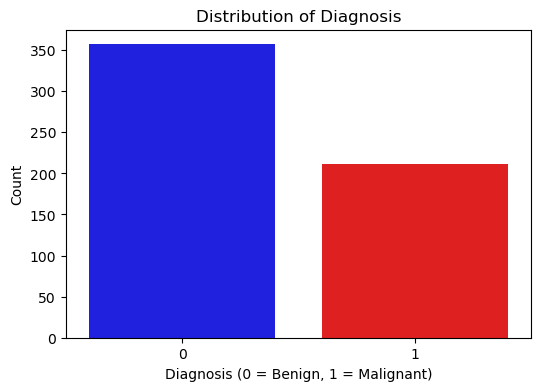

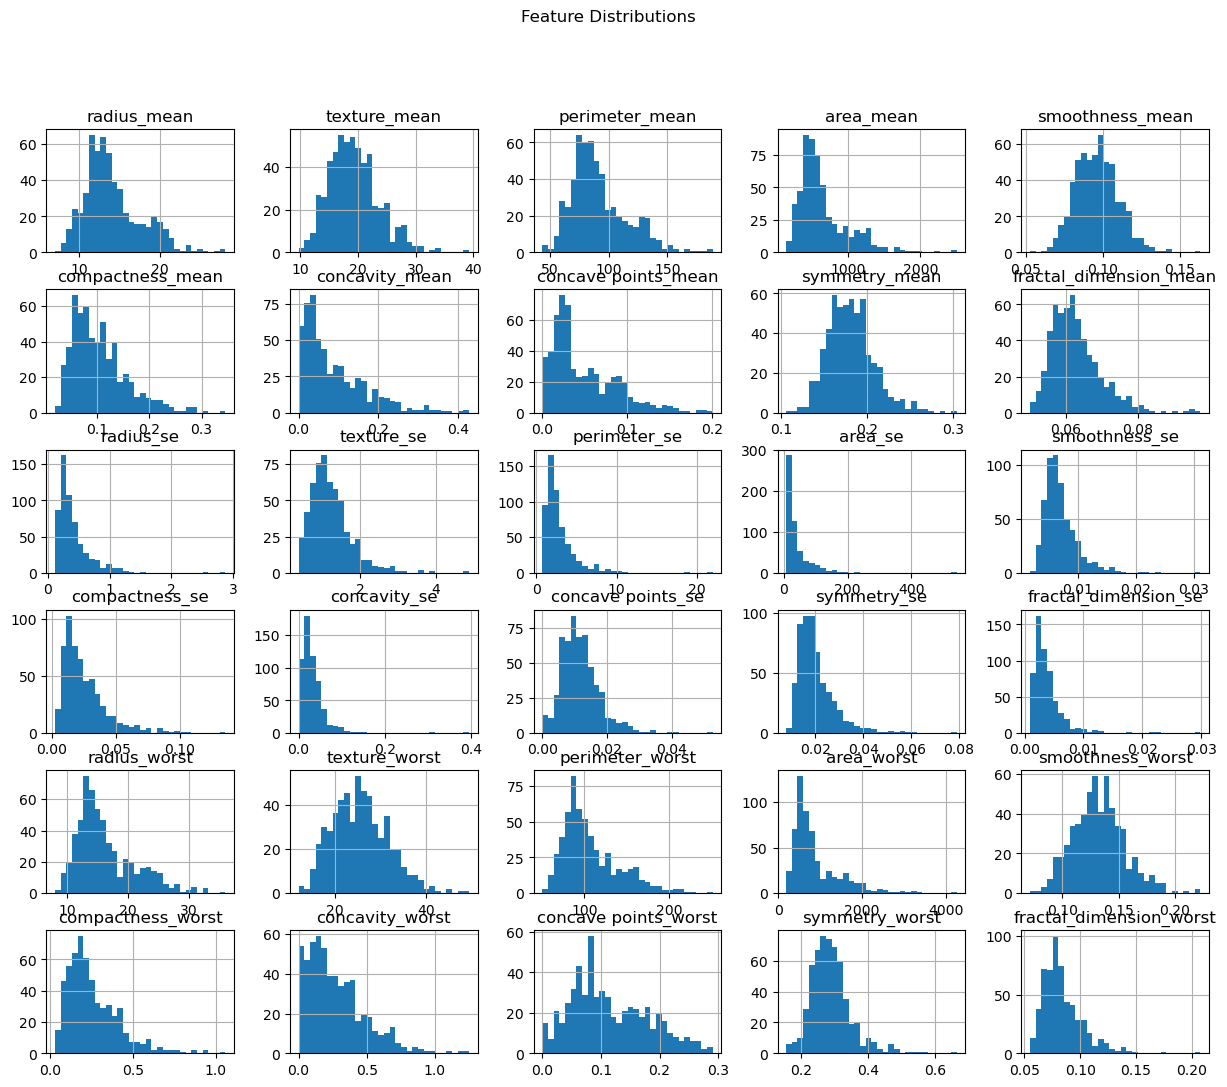

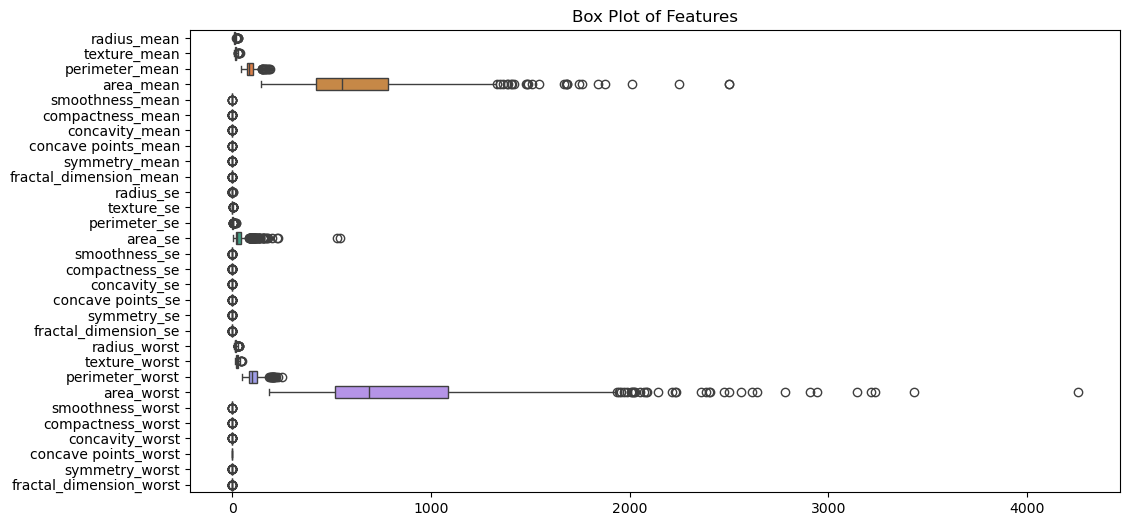

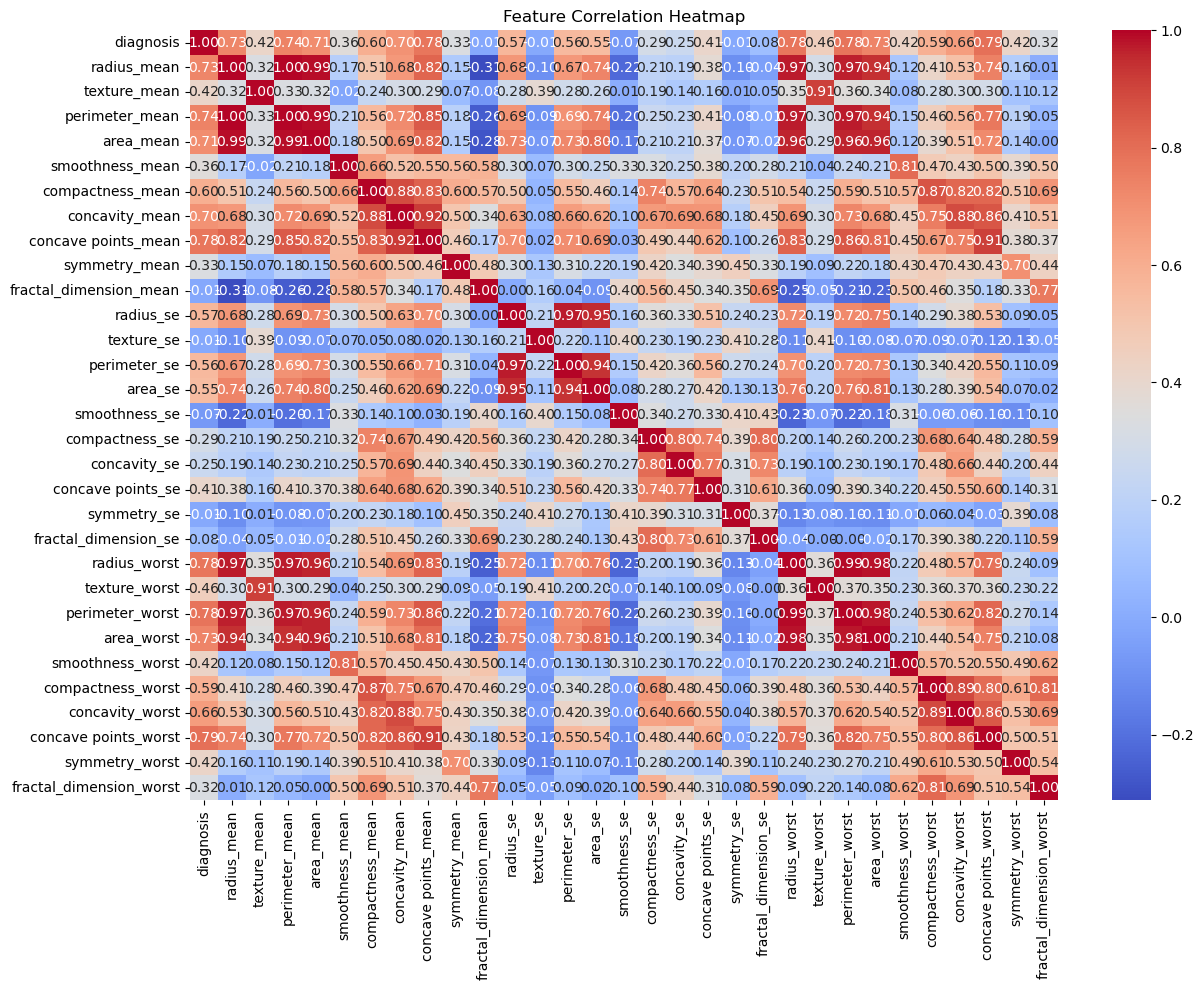

In [3]:
# Drop unnecessary columns
df.drop(['id', 'Unnamed: 32'], axis=1, errors='ignore', inplace=True)

# Convert 'diagnosis' to numeric (M -> 1, B -> 0)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

# Check class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df['diagnosis'], palette=['blue', 'red'])
plt.xlabel('Diagnosis (0 = Benign, 1 = Malignant)')
plt.ylabel('Count')
plt.title('Distribution of Diagnosis')
plt.show()

# Histograms of features
df.drop(columns=['diagnosis']).hist(figsize=(15, 12), bins=30)
plt.suptitle('Feature Distributions')
plt.show()

# Boxplots to detect outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=df.drop(columns=['diagnosis']), orient='h')
plt.title('Box Plot of Features')
plt.show()

# Correlation Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

In [4]:
# Handle class imbalance with SMOTE
X = df.drop(columns=['diagnosis'])
y = df['diagnosis']
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Feature Selection using RFE
selector = RFE(estimator=LogisticRegression(max_iter=10000), n_features_to_select=15)
X_selected = selector.fit_transform(X_resampled, y_resampled)

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)

# Logistic Regression Model
lr_model = LogisticRegression(max_iter=10000, random_state=42)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print("Logistic Regression Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr)}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, lr_model.predict_proba(X_test)[:, 1])}")
print(classification_report(y_test, y_pred_lr))

# Support Vector Machine (SVM)
svm_model = SVC(random_state=42, probability=True)  # Enable probability for ROC-AUC
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print("\nSVM Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm)}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, svm_model.predict_proba(X_test)[:, 1])}")
print(classification_report(y_test, y_pred_svm))

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("\nRandom Forest Performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf)}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])}")
print(classification_report(y_test, y_pred_rf))

Logistic Regression Performance:
Accuracy: 0.972027972027972
ROC-AUC Score: 0.9992166079122601
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        69
           1       0.97      0.97      0.97        74

    accuracy                           0.97       143
   macro avg       0.97      0.97      0.97       143
weighted avg       0.97      0.97      0.97       143


SVM Performance:
Accuracy: 0.958041958041958
ROC-AUC Score: 0.9974539757148453
              precision    recall  f1-score   support

           0       0.97      0.94      0.96        69
           1       0.95      0.97      0.96        74

    accuracy                           0.96       143
   macro avg       0.96      0.96      0.96       143
weighted avg       0.96      0.96      0.96       143


Random Forest Performance:
Accuracy: 0.972027972027972
ROC-AUC Score: 0.9938307873090482
              precision    recall  f1-score   support

           0       0.99   

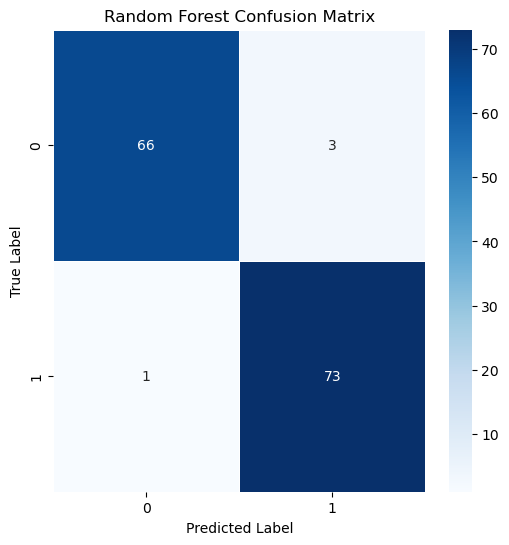


Cross-validation scores for Random Forest: [0.93706294 0.97902098 0.97902098 0.96503497 0.96478873]
Mean CV score: 0.9649857185068453


In [6]:
# Confusion Matrix for Random Forest
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues', linewidths=0.5)
plt.title('Random Forest Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Cross-validation for Random Forest
cv_scores_rf = cross_val_score(rf_model, X_scaled, y_resampled, cv=5)
print(f"\nCross-validation scores for Random Forest: {cv_scores_rf}")
print(f"Mean CV score: {cv_scores_rf.mean()}")

In [7]:
# Hyperparameter Tuning with GridSearchCV (for Random Forest)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy')
rf_grid_search.fit(X_train, y_train)
print(f"\nBest Parameters from GridSearchCV: {rf_grid_search.best_params_}")

best_rf_model = rf_grid_search.best_estimator_

y_pred_best_rf = best_rf_model.predict(X_test)
print("\nBest Random Forest Performance after Hyperparameter Tuning:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best_rf)}")
print(f"ROC-AUC Score: {roc_auc_score(y_test, best_rf_model.predict_proba(X_test)[:, 1])}")
print(classification_report(y_test, y_pred_best_rf))


Best Parameters from GridSearchCV: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}

Best Random Forest Performance after Hyperparameter Tuning:
Accuracy: 0.951048951048951
ROC-AUC Score: 0.9931453192322758
              precision    recall  f1-score   support

           0       0.97      0.93      0.95        69
           1       0.94      0.97      0.95        74

    accuracy                           0.95       143
   macro avg       0.95      0.95      0.95       143
weighted avg       0.95      0.95      0.95       143



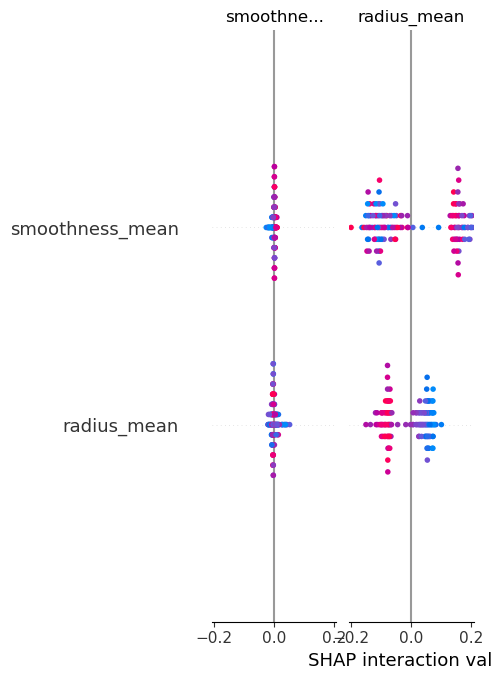

In [8]:
# Model Interpretability with SHAP
explainer = shap.TreeExplainer(best_rf_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=selector.get_feature_names_out())

In [9]:
# Model Saving
joblib.dump(best_rf_model, 'breast_cancer_rf_model.pkl')
print("\nBest Random Forest Model saved successfully!")


Best Random Forest Model saved successfully!
